Exploration of LotFrontage variable. It's description is, "Linear feet of street connected to property"

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from helpers.sklearn_pieces import str_category_pipeline
from house_prices.helpers.column_categories import continuous_columns, categorical_unordered_columns, categorical_ordered_columns
from house_prices.helpers.utils import association_matrix, anova_with_effect_size, anova_matrix

In [21]:
sns.set(rc={'figure.figsize':(15,10)})

Let's load in the data and first zero in on the relationship between the variable and SalePrice

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0).loc[:, ['LotFrontage', 'SalePrice']]

In [3]:
print(train.shape)
print(train['LotFrontage'].isnull().sum())

(1460, 2)
259


Quite a few missing values.

In [4]:
train.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

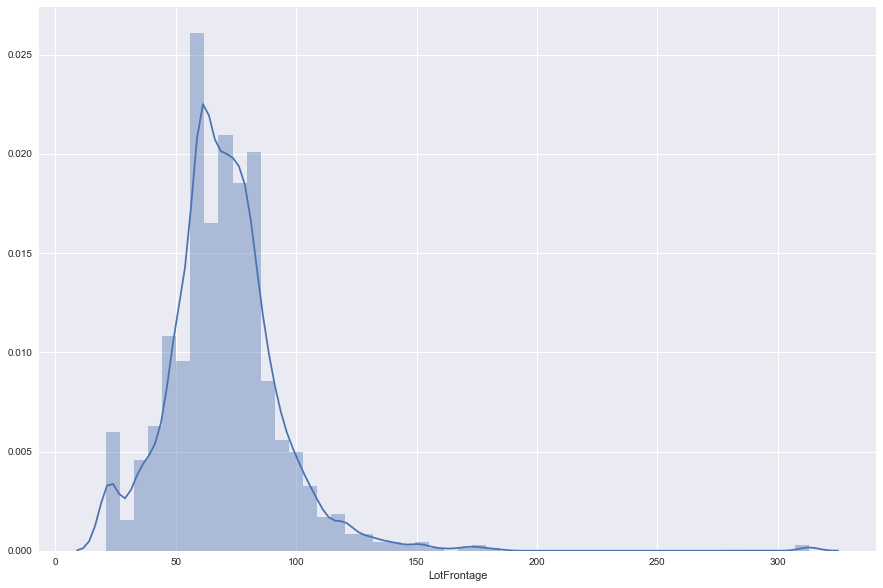

In [10]:
sns.distplot(train.LotFrontage.dropna());

In [16]:
train.LotFrontage[train.LotFrontage > 200]

Id
935     313.0
1299    313.0
Name: LotFrontage, dtype: float64

Looks to be slightly skewed with a longer tail on the right and two outliers at 313.0.

What's its relationship with SalePrice?

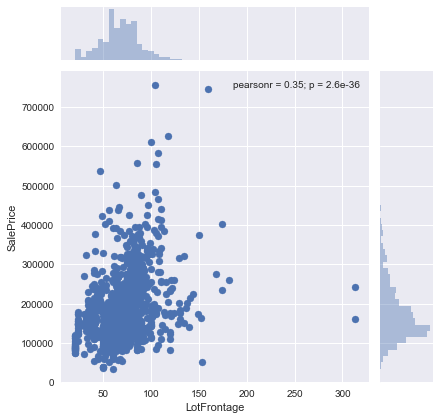

In [20]:
sns.jointplot(x='LotFrontage', y='SalePrice', data=train);

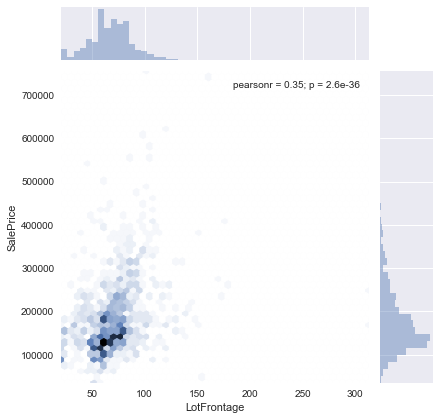

In [24]:
sns.jointplot(x='LotFrontage', y='SalePrice', kind='hex', data=train);

There is a definite correlation and a decent effect size. 

Let's see how a simple model using just LotFrontage will work. For the missing values, since there are so many, we'll train our model on only the data we have.

In [25]:
test = pd.read_csv('../data/test.csv', index_col=0)

In [26]:
print(test.shape)
print(test['LotFrontage'].isnull().sum())

(1459, 79)
227


The test data has many missing values, so we'll have to fill them somehow. We'll use the median value since we have no information to tell us to use anything else.

In [43]:
train = pd.read_csv('../data/train.csv', index_col=0).loc[:, ['LotFrontage', 'SalePrice']].dropna()
train_X = train['LotFrontage'].values.reshape(-1, 1)
train_y = train['SalePrice']
test_X = test['LotFrontage'].values.reshape(-1, 1)

In [44]:
params = {
    'max_depth': randint(2, 400),
    'min_samples_split': randint(2, 100),
}
rnd_clf = RandomForestRegressor(n_estimators=500)
forest_search = RandomizedSearchCV(rnd_clf, param_distributions=params, n_iter=400, n_jobs=6)
forest_search.fit(train_X, train_y)
final_model = forest_search.best_estimator_

In [49]:
forest_search.best_params_

{'max_depth': 13, 'min_samples_split': 61}

In [46]:
test_X[np.isnan(test_X)] = train.LotFrontage.median()

In [48]:
predictions = final_model.predict(test_X).round()
submission_df = pd.DataFrame(
    data=predictions,
    index=test.index,
    columns=['SalePrice']
)
submission_df.to_csv('lotfrontage_only.csv')

This model did surprisingly well with a RMSE of 0.37276. Still not as good as MSSubClass alone though. Let's try one other type of model, a Ridge Regression model.